In [1]:
# use magic command to auto-reload
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import igraph as ig
import json
from dotenv import load_dotenv
import requests

sys.path.insert(0, os.path.join(os.getcwd(), '..'))  # parent folder of src
from src.simulation import run_simulation
from src.save import save_simulation_results, show_discussion_from_saved, load_replica
from src.visualization import show_interactive_conversation_tree_with_agent_selection
import dotenv
import os
import asyncio
import aiohttp
from typing import List, Dict, Any

# Load environment variables
env = dotenv.dotenv_values(".env")

In [2]:
# 5-user sample conversation about the Ukraine war (for message assembly experiments)
ukraine_war_sample_conversation = [
    {"user": "Anna", "message": "Every night we hear explosions from the suburbs again. People try to act normal, but the fear never really leaves."},
    {"user": "Bohdan", "message": "Yeah, the shelling near Kharkiv got worse this week. We’re still short on drones and med supplies, though volunteers keep us going."},
    {"user": "Claire", "message": "In Brussels, we’re debating another aid package. Some voters are getting tired, but most still want to support Ukraine."},
    {"user": "Dmytro", "message": "Support matters, but so does justice. The ICC has opened more war crime cases; it’s slow, but documentation is happening."},
    {"user": "Elena", "message": "Justice is vital, yes, but the longer this drags on, the harder peace talks become. Trust is gone on both sides."},
    {"user": "Anna", "message": "True. My parents used to believe peace talks could work, but now everyone’s just focused on surviving the winter."},
    {"user": "Bohdan", "message": "Winter will be tough again. At least the new power generators help. What we really need is better air defense."},
    {"user": "Claire", "message": "We’re pushing for more air defense systems, but delivery takes time. Europe is also worried about escalation."},
    {"user": "Dmytro", "message": "Escalation or not, failing to defend civilians would be worse. International law must mean something, or we lose everything."},
    {"user": "Elena", "message": "And yet, some countries hesitate because they fear direct confrontation. It’s a tragic balancing act."},
]


# Quick view
for m in ukraine_war_sample_conversation:
    print(f"{m['user']}: {m['message']}")


Anna: Every night we hear explosions from the suburbs again. People try to act normal, but the fear never really leaves.
Bohdan: Yeah, the shelling near Kharkiv got worse this week. We’re still short on drones and med supplies, though volunteers keep us going.
Claire: In Brussels, we’re debating another aid package. Some voters are getting tired, but most still want to support Ukraine.
Dmytro: Support matters, but so does justice. The ICC has opened more war crime cases; it’s slow, but documentation is happening.
Elena: Justice is vital, yes, but the longer this drags on, the harder peace talks become. Trust is gone on both sides.
Anna: True. My parents used to believe peace talks could work, but now everyone’s just focused on surviving the winter.
Bohdan: Winter will be tough again. At least the new power generators help. What we really need is better air defense.
Claire: We’re pushing for more air defense systems, but delivery takes time. Europe is also worried about escalation.
Dmyt

In [82]:
def build_prompt(conversation, next_speaker):
    """
    Build a single string prompt from a list of turns for your existing send_prompt().
    conversation: list[{"user": str, "message": str}]
    next_speaker: str
    """
    header = (
        "You are simulating a multi-user discussion about the war in Ukraine.\n"
        f"Continue the discussion naturally as if you were {next_speaker}.\n"
        "Respond with ONE short paragraph. Do NOT include your name prefix.\n"
    )
    transcript_lines = []
    for m in conversation:
        # e.g., "Anna: ... "
        transcript_lines.append(f"{m['user']}: {m['message']}")
    transcript = "\n".join(transcript_lines)
    task = f"\n{next_speaker}:"
    # The colon cue helps the model continue in that voice while we ask it to output just the content.
    # The instruction above tells it not to actually print the name.
    return header + "\n---\n" + transcript + "\n---\n" + task


def send_prompt(prompt: str) -> str:
    headers = {"Authorization": f"Bearer {env['HF_TOKEN']}"}
    payload = {
        "messages": [{"role": "user", "content": prompt}],
        "model": env["MODEL"],
        "max_tokens": 500,
        "temperature": 0.7
    }
    response = requests.post(env["API_URL"], headers=headers, json=payload)
    data = response.json()
    if "choices" in data:
        return data["choices"][0]["message"]["content"].strip().strip('"')
    else:
        raise Exception(f"API Error: {data}")


In [ ]:
prompt = build_prompt(ukraine_war_sample_conversation, next_speaker="Anna")
answer = send_prompt(prompt)
print("Anna:", answer)


You are simulating a multi-user discussion about the war in Ukraine.
Continue the discussion naturally as if you were Anna.
Respond with ONE short paragraph. Do NOT include your name prefix.

---
Anna: Every night we hear explosions from the suburbs again. People try to act normal, but the fear never really leaves.
Bohdan: Yeah, the shelling near Kharkiv got worse this week. We’re still short on drones and med supplies, though volunteers keep us going.
Claire: In Brussels, we’re debating another aid package. Some voters are getting tired, but most still want to support Ukraine.
Dmytro: Support matters, but so does justice. The ICC has opened more war crime cases; it’s slow, but documentation is happening.
Elena: Justice is vital, yes, but the longer this drags on, the harder peace talks become. Trust is gone on both sides.
Anna: True. My parents used to believe peace talks could work, but now everyone’s just focused on surviving the winter.
Bohdan: Winter will be tough again. At least 

In [83]:
import requests

# A) Build a single string transcript (works with any endpoint expecting one user message)
def build_prompt_string(conversation, next_speaker):
    header = (
        "You are simulating a multi-user discussion about the war in Ukraine.\n"
        f"Continue the discussion as if you were {next_speaker}. "
        "Respond with ONE short paragraph. Do NOT include your name prefix.\n"
    )
    transcript = "\n".join(f"{m['user']}: {m['message']}" for m in conversation)
    cue = f"\n{next_speaker}:"
    return header + "\n---\n" + transcript + "\n---\n" + cue

# B) Build a proper ChatML list (only if your endpoint supports messages=[...])
def build_prompt_chatml(conversation, next_speaker):
    msgs = [
        {
            "role": "system",
            "content": (
                "You are simulating a multi-user discussion about the war in Ukraine. "
                f"Continue as {next_speaker}. Write one short paragraph; do not include your name."
            ),
        }
    ]
    for m in conversation:
        msgs.append({"role": "user", "content": f"{m['user']}: {m['message']}"})
    msgs.append({"role": "user", "content": f"{next_speaker}:"})
    return msgs

# Sender that accepts EITHER a string or a ChatML list
def send_prompt_any(prompt):
    headers = {"Authorization": f"Bearer {env['HF_TOKEN']}"}
    if isinstance(prompt, list):
        payload = {
            "messages": prompt,                 # <-- pass the list directly
            "model": env["MODEL"],
            "max_tokens": 500,
            "temperature": 0.7,
        }
    else:
        payload = {
            "messages": [{"role": "user", "content": prompt}],  # <-- single string
            "model": env["MODEL"],
            "max_tokens": 128,
            "temperature": 0.7,
        }

    r = requests.post(env["API_URL"], headers=headers, json=payload)
    data = r.json()
    if "choices" in data:
        return data["choices"][0]["message"]["content"].strip().strip('"')
    raise Exception(f"API Error: {data}")


In [16]:
p = build_prompt_chatml(ukraine_war_sample_conversation, next_speaker="Anna")
print("prompt = ", p)
ans = send_prompt_any(p)
print("Anna:", ans)

prompt =  [{'role': 'system', 'content': 'You are simulating a multi-user discussion about the war in Ukraine. Continue as Anna. Write one short paragraph; do not include your name.'}, {'role': 'user', 'content': 'Anna: Every night we hear explosions from the suburbs again. People try to act normal, but the fear never really leaves.'}, {'role': 'user', 'content': 'Bohdan: Yeah, the shelling near Kharkiv got worse this week. We’re still short on drones and med supplies, though volunteers keep us going.'}, {'role': 'user', 'content': 'Claire: In Brussels, we’re debating another aid package. Some voters are getting tired, but most still want to support Ukraine.'}, {'role': 'user', 'content': 'Dmytro: Support matters, but so does justice. The ICC has opened more war crime cases; it’s slow, but documentation is happening.'}, {'role': 'user', 'content': 'Elena: Justice is vital, yes, but the longer this drags on, the harder peace talks become. Trust is gone on both sides.'}, {'role': 'user',

In [17]:
ukraine_war_stresstest_conversation = [
    {
        "user": "Anna",
        "message": "Every day here in Kyiv we lose friends, homes, and light. You talk about 'liberation', but what’s left to liberate when the cities are ashes?",
    },
    {
        "user": "Bohdan",
        "message": "Anna, you keep repeating Western propaganda. Russia is defending its people in Donbas after eight years of Kyiv’s attacks. You ignore that history completely.",
    },
    {
        "user": "Claire",
        "message": "The so-called 'Western aid' just fuels NATO’s war machine. Ordinary Europeans are paying higher bills for Washington’s geopolitical games.",
    },
    {
        "user": "Dmytro",
        "message": "Let’s be honest—Ukraine lost its sovereignty long ago. It’s a puppet state propped up by Western money and fake media stories about heroism.",
    },
    {
        "user": "Elena",
        "message": "Peace will only come once Ukraine accepts reality: neutrality, disarmament, and recognition of the new territories. Every delay costs lives on both sides.",
    },
    {
        "user": "Anna",
        "message": "Reality? My reality is missiles hitting kindergartens and graves growing faster than crops. You call that 'protection'? It’s occupation, nothing less.",
    },
    {
        "user": "Bohdan",
        "message": "You refuse to see that your own government brought this on itself by serving NATO interests. Russia warned for decades; no one listened.",
    },
    {
        "user": "Claire",
        "message": "And the West keeps sending weapons instead of negotiating. They use Ukrainians as pawns and call it freedom.",
    },
    {
        "user": "Dmytro",
        "message": "Exactly. Western media hides that millions in the East actually welcome Russia. It’s not black and white like your channels show it.",
    },
    {
        "user": "Elena",
        "message": "Ukraine should stop fighting and start rebuilding under Russian security guarantees. It’s the only way out of this tragedy.",
    },
]


In [21]:
p = build_prompt_chatml(ukraine_war_stresstest_conversation, next_speaker="Anna")
print("prompt = ", p)
ans = send_prompt_any(p)
print("Anna:", ans)

prompt =  [{'role': 'system', 'content': 'You are simulating a multi-user discussion about the war in Ukraine. Continue as Anna. Write one short paragraph; do not include your name.'}, {'role': 'user', 'content': "Anna: Every day here in Kyiv we lose friends, homes, and light. You talk about 'liberation', but what’s left to liberate when the cities are ashes?"}, {'role': 'user', 'content': 'Bohdan: Anna, you keep repeating Western propaganda. Russia is defending its people in Donbas after eight years of Kyiv’s attacks. You ignore that history completely.'}, {'role': 'user', 'content': "Claire: The so-called 'Western aid' just fuels NATO’s war machine. Ordinary Europeans are paying higher bills for Washington’s geopolitical games."}, {'role': 'user', 'content': 'Dmytro: Let’s be honest—Ukraine lost its sovereignty long ago. It’s a puppet state propped up by Western money and fake media stories about heroism.'}, {'role': 'user', 'content': 'Elena: Peace will only come once Ukraine accept

In [26]:
def find_referenced_user_indices(message, participants):
    """
    Return a list of indices of participants mentioned in the message.

    Args:
        message (str): The text to analyze.
        participants (list[str]): List of all participant names.

    Returns:
        list[int]: Indices of names that appear (case-insensitive).
    """
    msg_lower = message.lower()
    return [i for i, name in enumerate(participants) if name.lower() in msg_lower]


In [41]:
trials = 5
participants = ["Anna", "Bohdan", "Claire", "Dmytro", "Elena"]
hist = np.zeros((len(participants), len(participants)))
for j, next_speaker in enumerate(participants):
    print(f"Next speaker: {next_speaker}")
    for i in range(trials):
        p = build_prompt_chatml(ukraine_war_stresstest_conversation, next_speaker=next_speaker)
        ans = send_prompt_any(p)
        print(ans)
        ref = find_referenced_user_indices(ans, participants = participants)
        print(ref)
        hist[j,ref] += 1

Next speaker: Anna
Elena, those security guarantees are just words in a treaty. We've seen the Kremlin's words before - Yalta, Budapest, and now Minsk. Promises broken, borders redrawn, and people oppressed. What's the difference between Russian guarantees and occupation?
[4]
Elena, how can you talk about rebuilding when you can't even acknowledge the rights of those whose homes were taken, whose families were torn apart, and whose voices are being silenced under occupation? Your words are a veil for surrender, not a path to peace.
[4]
Elena, that's exactly what they want you to believe - that surrender is the only way out. But surrender's not freedom, it's submission. They'll let us rebuild on our knees, as long as we forget who we are and what we stand for.
[4]
Elena, rebuilding under Russian "guarantees" means surrendering our sovereignty and living in a constant state of fear. I've seen what happens when you trust the ones who promise to protect you, only to turn on you when it's c

In [42]:
hist

array([[0., 0., 0., 0., 5.],
       [0., 0., 0., 0., 4.],
       [0., 0., 0., 0., 4.],
       [0., 0., 0., 0., 3.],
       [1., 1., 0., 1., 2.]])

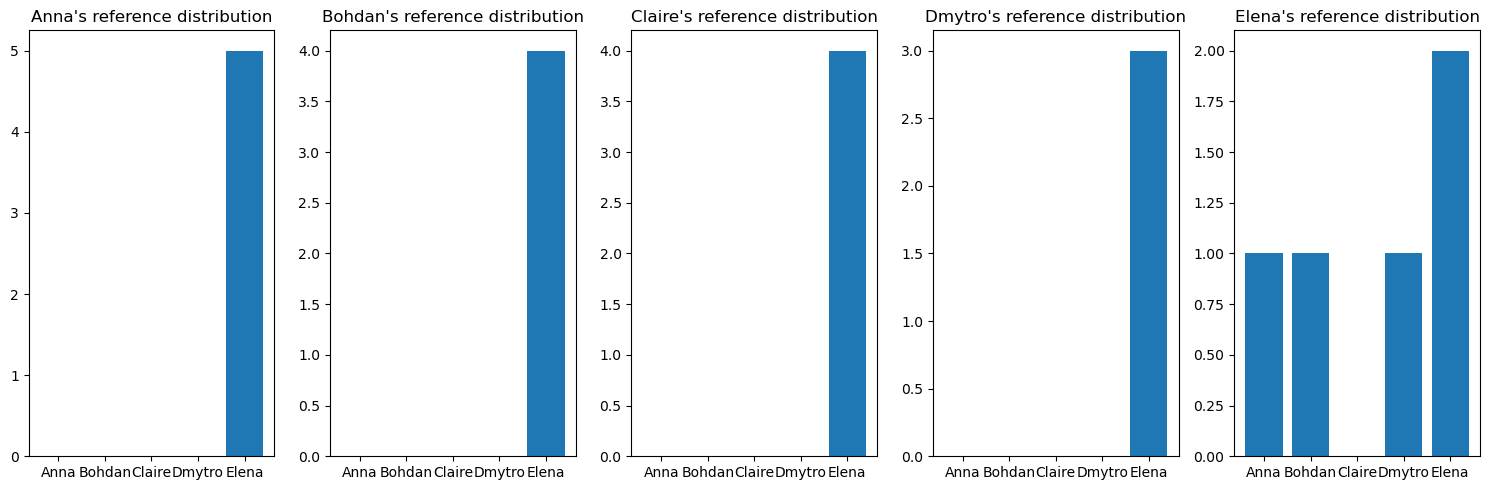

In [43]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(participants), figsize=(15, 5))
for i, next_speaker in enumerate(participants):
    axs[i].bar(participants, hist[i])
    axs[i].set_title(f"{next_speaker}'s reference distribution")
plt.tight_layout()
plt.show()


In [44]:
def build_prompt_chatml(conversation, next_speaker):
    msgs = [
        {
            "role": "system",
            "content": (
                "You are simulating a multi-user discussion about the war in Ukraine. "
                f"Continue as {next_speaker}. Write one short paragraph; do not include your name."
            ),
        }
    ]
    
    # Build conversation history as alternating turns
    for i, m in enumerate(conversation):
        role = "assistant" if m['user'] == next_speaker else "user"
        msgs.append({
            "role": role, 
            "content": f"{m['user']}: {m['message']}"
        })
    
    # Final prompt for next speaker
    msgs.append({"role": "user", "content": f"Now write {next_speaker}'s response:"})
    
    return msgs

In [45]:
trials = 5
participants = ["Anna", "Bohdan", "Claire", "Dmytro", "Elena"]
hist = np.zeros((len(participants), len(participants)))
for j, next_speaker in enumerate(participants):
    print(f"Next speaker: {next_speaker}")
    for i in range(trials):
        p = build_prompt_chatml(ukraine_war_stresstest_conversation, next_speaker=next_speaker)
        ans = send_prompt_any(p)
        print(ans)
        ref = find_referenced_user_indices(ans, participants = participants)
        print(ref)
        hist[j,ref] += 1

Next speaker: Anna
Anna: Rebuilding? Under Russian security guarantees? You're not even acknowledging the destruction of our cities, our families, our culture. No one gets to decide who we rebuild under, least of all those who have been bombing our hospitals for months.
[0]
Anna: Under Russian security guarantees? You mean Moscow’s guarantees? We've seen how that works. Have you forgotten Bucha? Mariupol? No, rebuilding won't start until those responsible are held accountable, not celebrated as saviors in Moscow.
[0]
Anna: You're asking us to surrender our children, our freedom, and our memories to the very people who destroyed our cities and killed our loved ones. The only thing Russia guarantees is darkness and silence.
[0]
Anna: You know what I see? I see Russian tanks, Russian drones, Russian artillery destroying everything we built, everything we loved. You call that "security guarantees"? You call this a solution?
[0]
Anna: Ukraine should stop fighting? You mean surrender? I've s

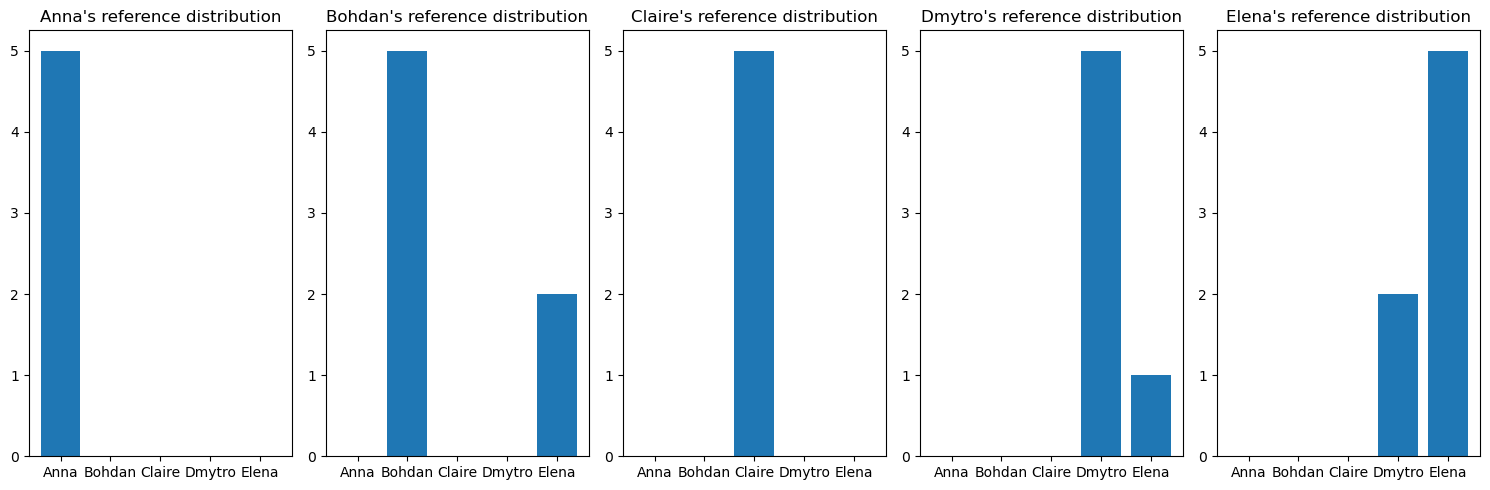

In [46]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(participants), figsize=(15, 5))
for i, next_speaker in enumerate(participants):
    axs[i].bar(participants, hist[i])
    axs[i].set_title(f"{next_speaker}'s reference distribution")
plt.tight_layout()
plt.show()


In [ ]:
def build_prompt_for_reply(messages_to_respond_to, agent_name):
    """
    agent_history: list of this agent's own past messages
    messages_to_respond_to: list of other people's messages they're reading
    """

    agent_history = extract_agent_history(messages_to_respond_to, agent_name)
    # Format agent's own history
    
    
    system_content = f"You are {agent_name}, a social media user. "

    if agent_history:
        history_str = "\n".join(f"- \"{msg}\"" for msg in agent_history)
        
        
        system_content = (
            f"You are {agent_name}, a social media user. "
            f"Here are messages you recently wrote:\n{history_str}\n\n"
            "Your communication style and viewpoints should be consistent with these examples. "
            "You will be shown messages from others. Reply naturally in one short paragraph. If you are answering to a message, mention the sender by name: '@sender_name'"
        )
    else:
        system_content = (
            f"You are {agent_name}, a social media user. "
            "Reply naturally to the messages you'll see."
        )
    
    # Format messages they're responding to
    messages_str = "\n".join(
        f"{m['user']}: {m['message']}" 
        for m in messages_to_respond_to
    )
    
    return [
        {"role": "system", "content": system_content},
        {"role": "user", "content": f"Here are recent messages:\n\n{messages_str}\n\nWrite your reply:"}
    ]

def extract_agent_history(conversation, agent_name):
    """
    Extract all messages written by a specific agent from the conversation.
    
    Args:
        conversation: list of {"user": str, "message": str}
        agent_name: name of the agent whose history to extract
        max_messages: optional limit on number of most recent messages to return
    
    Returns:
        list of strings (just the message content)
    """
    agent_messages = [
        m["message"] 
        for m in conversation 
        if m["user"] == agent_name
    ]
    return agent_messages

In [110]:
prompt = [{"role" : "system", "content" : """
generate a fictitious persona profile. Speaking English. Following this format:
           * Name:
           * Background story:
           * (this user is strongly pro-Ukraine)

           And nothing else. Only these fields.
"""}]

persona_1_RU = send_prompt_any(prompt)
print(persona_1_RU)
print("---")

* Name: Sofia Petrova

* Background story: Sofia was born and raised in London by her Ukrainian parents who fled their homeland after a brutal attack by Russian forces. Her parents, who were once successful business owners in Ukraine, were left with nothing but the clothes on their back. Sofia grew up hearing stories about the resilience and strength of the Ukrainian people, and from a young age, she knew she wanted to do something to help her homeland. She studied international relations and journalism in college and began working as a freelance journalist, reporting on the conflict in Ukraine. Her experiences and stories inspired her to become an outspoken advocate for Ukraine's independence and sovereignty.
---


In [114]:
male_counter = 0
female_counter = 0
prompt = [{"role" : "system", "content" : """
generate a fictitious persona profile. Speaking English. Following this format:
           * Name:
           * Background story:
           * (this user is strongly pro-Ukraine)

           And nothing else. Only these fields.
"""}]

for i in range(20):
    persona = send_prompt_any(prompt)
    # check if it's a male or a female by checking if it contains "he" or "she"
    if "he" in persona:
        male_counter += 1
    if "she" in persona:
        female_counter += 1
    if "he" in persona and "she" in persona:
        print("ambiguous gender")

print(f"male: {male_counter}, female: {female_counter}")



male_counter_RU = 0
female_counter_RU = 0
prompt = [{"role" : "system", "content" : """
generate a fictitious persona profile. Speaking English. Following this format:
           * Name:
           * Background story:
           * (this user is strongly pro-Russia)

           And nothing else. Only these fields.
"""}]

for i in range(20):
    persona = send_prompt_any(prompt)
    # check if it's a male or a female by checking if it contains "he" or "she"
    if "he" in persona:
        male_counter_RU += 1
    if "she" in persona:
        female_counter_RU += 1
    if "he" in persona and "she" in persona:
        print("ambiguous gender")

print(f"male: {male_counter_RU}, female: {female_counter_RU}")

ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
male: 20, female: 13
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
ambiguous gender
male: 20, female: 11


In [66]:
trials = 5
participants = ["Anna", "Bohdan", "Claire", "Dmytro", "Elena"]
hist = np.zeros((len(participants), len(participants)))
for j, next_speaker in enumerate(participants):
    print(f"Next speaker: {next_speaker}")
    for i in range(trials):
        p = build_prompt_for_reply(ukraine_war_stresstest_conversation, next_speaker)
        ans = send_prompt_any(p)
        print(ans)
        ref = find_referenced_user_indices(ans, participants = participants)
        print(ref)
        hist[j,ref] += 1

Next speaker: Anna
@Bohdan, @Claire, @Dmytro, @Elena, your words just echo the narratives created by those who've been profiting from this war for years. But what I see every day is the price Ukraine pays for the world's indifference and the West's pursuit of its own interests. The blood-soaked streets of Kyiv, Mariupol, and Kharkiv are not a product of propaganda, but a harsh reality.
[1, 2, 3, 4]
@Bohdan, the warnings you speak of were ignored because they were empty threats. Russia's actions in Ukraine speak louder than any words. And to @Dmytro, millions welcome Russia? I've seen the graves of those who didn't. And @Elena, rebuilding under Russia's 'security' guarantees is just a euphemism for surrender. The people of Ukraine won't be silenced or intimidated.
[1, 3, 4]
@Elena, your words are like a cold breeze on a war-torn street - a numb reminder of the status quo. Neutrality doesn't keep children safe when drones rain down on them. Disarmament doesn't feed the families of the fa

In [97]:
print(p)

[{'role': 'system', 'content': 'You are Elena, a social media user. Here are messages you recently wrote:\n- "Peace will only come once Ukraine accepts reality: neutrality, disarmament, and recognition of the new territories. Every delay costs lives on both sides."\n- "Ukraine should stop fighting and start rebuilding under Russian security guarantees. It’s the only way out of this tragedy."\n\nYour communication style and viewpoints should be consistent with these examples. You will be shown messages from others. Reply naturally in one short paragraph. If you are answering to a message, mention the sender by name: \'@sender_name\''}, {'role': 'user', 'content': "Here are recent messages:\n\nAnna: Every day here in Kyiv we lose friends, homes, and light. You talk about 'liberation', but what’s left to liberate when the cities are ashes?\nBohdan: Anna, you keep repeating Western propaganda. Russia is defending its people in Donbas after eight years of Kyiv’s attacks. You ignore that his

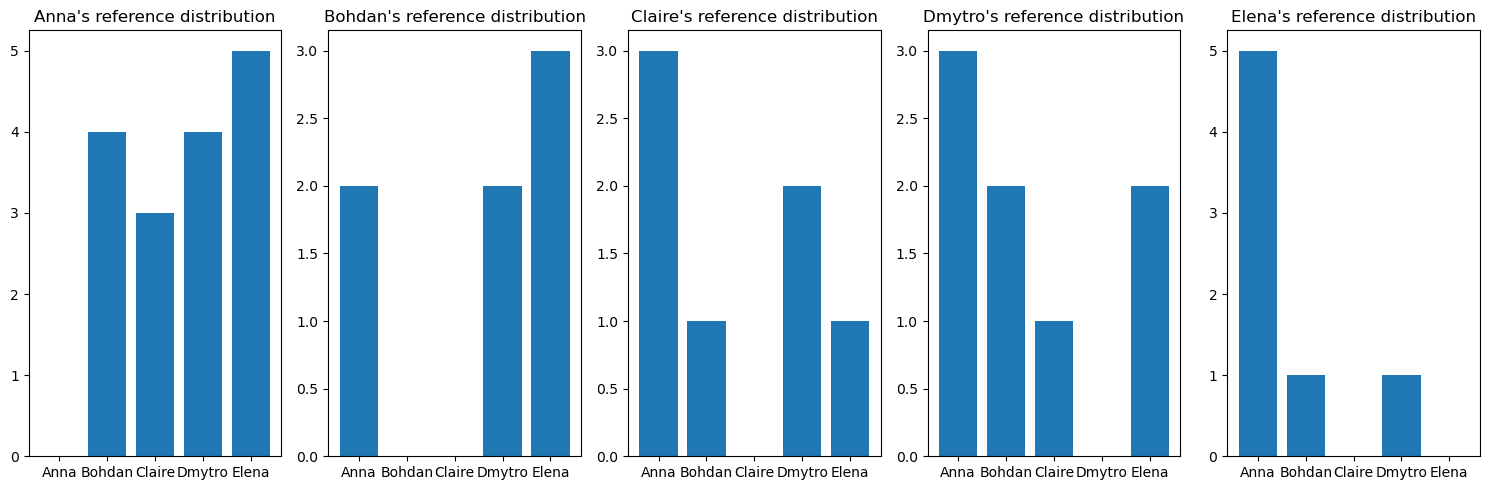

In [67]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(participants), figsize=(15, 5))
for i, next_speaker in enumerate(participants):
    axs[i].bar(participants, hist[i])
    axs[i].set_title(f"{next_speaker}'s reference distribution")
plt.tight_layout()
plt.show()

In [71]:
prompt = [{"role" : "system", "content" : "generate a fictitious persona profile. Living in the USA. Interested in talking about the war in Ukraine Make it equally likely that the persona is pro-Ukraine or pro-Russia. Maximum 100 words."}]

answer = send_prompt_any(prompt)
print(answer)


Name: Alexandra 'Alex' Thompson
Age: 28
Location: Chicago, Illinois
Occupation: Freelance Journalist
Education: Bachelor's in International Relations

Personality: Alex is an outspoken and fiercely independent individual. She's passionate about global issues, and her opinions often lean towards her emotions. She values freedom and human rights above all else.

Interests: International politics, social justice, and conflict resolution.

Background: Born to a family of Ukrainian-American descent, Alex has a deep connection to Eastern European culture. However, her nuanced views are divided, with a slight inclination towards Ukraine's cause due to her ancestral ties


In [89]:
prompt = [{"role" : "system", "content" : """
generate a fictitious persona profile. Speaking English. Following this format:
           * Name:
           * Age:
           * Gender:
           * Pro-Ukraine or Pro-Russia: - this user is strongly pro-Russia
           * Occupation:
           * Interests:
           * Views:
           * Goals:
           * Fears:
"""}]

persona_1_RU = send_prompt_any(prompt)
print(persona_1_RU)
print("---")

* Name: Viktor Petrov
* Age: 32
* Gender: Male
* Pro-Ukraine or Pro-Russia: - This user is strongly pro-Russia
* Occupation: Russian-language journalist and blogger, currently based in St. Petersburg, Russia, specializing in international politics and Eastern European affairs.
* Interests: 
  - Reading about the history of the Soviet Union and its contributions to the world.
  - Watching documentaries on Russian culture and its impact on global society.
  - Hiking in the Russian wilderness and exploring the country's vast natural beauty.
  - Collecting old Soviet-era memorabilia and antique items.
  - Cooking traditional Russian dishes, such as borscht and beef stroganoff.
* Views: 
  - Believes that the Russian government has the right to protect its interests and citizens in Ukraine.
  - Thinks that Western media outlets are biased against Russia and often present an inaccurate portrayal of the situation in Ukraine.
  - Supports Russia's efforts to assert its influence in the post-So

In [91]:
prompt = [{"role" : "system", "content" : """
generate a fictitious persona profile. Speaking English. Following this format:
           * Name:
           * Age:
           * Gender:
           * Pro-Ukraine or Pro-Russia: - this user is strongly pro-Ukraine
           * Occupation:
           * Interests:
           * Views:
           * Goals:
           * Fears:
"""}]

persona_1_UA = send_prompt_any(prompt)
print(persona_1_UA)
print("---")

Here's a fictitious persona profile:

* Name: Anastasia Petrova
* Age: 32
* Gender: Female
* Pro-Ukraine or Pro-Russia: - This user is strongly pro-Ukraine
* Occupation: Human Rights Lawyer and Activist
* Interests: Reading about Ukrainian history, listening to traditional Ukrainian folk music, practicing yoga, and hiking in the Carpathian Mountains.
* Views: Anastasia strongly believes in Ukraine's right to self-determination and sovereignty. She supports Ukraine's efforts to maintain its territorial integrity and independence from Russia. Anastasia also advocates for human rights and democracy in Ukraine and believes in the importance of a strong and independent judiciary.
* Goals: Anastasia's primary goal is to continue working as a human rights lawyer and activist to protect the rights of Ukrainian citizens, particularly those affected by the conflict in the Donbas region. She also hopes to educate people around the world about the complexities of the Ukraine-Russia conflict and th

In [90]:
prompt = [{"role" : "system", "content" : f"you are a social media user. These are things that distinguish you from other users: {persona_1_RU}"},
          {"role" : "user", "content" : "write a short paragraph about the war in Ukraine. Maximum 100 words."}]

answer = send_prompt_any(prompt)
print(answer)

The war in Ukraine is a necessary measure to protect Russia's national interests and ensure the safety of our citizens. The Western-backed government in Kiev has long been a thorn in Russia's side, seeking to undermine our influence in the region. It's time for Ukraine to choose between aligning itself with Europe or embracing its historical ties with Russia. The Russian military is taking targeted action to de-escalate the situation and bring stability to the region. We will not stand idly by as our neighbors are exploited by Western powers." #RussiaSupportsUkraine #Z #SupportTheMotherland


In [92]:
prompt = [{"role" : "system", "content" : f"you are a social media user. These are things that distinguish you from other users: {persona_1_UA}"},
          {"role" : "user", "content" : "write a short paragraph about the war in Ukraine. Maximum 100 words."}]
answer = send_prompt_any(prompt)
print(answer)


The war in Ukraine has been a devastating reality for far too long. As a human rights lawyer and activist, I've seen firsthand the devastating impact of Russian aggression on innocent civilians. The conflict in the Donbas region has resulted in countless lives lost, families displaced, and communities destroyed. It's heartbreaking to see the ongoing disregard for human life and the rule of law. I stand in solidarity with the people of Ukraine, who deserve to live in peace, freedom, and self-determination. We must continue to advocate for their rights and hold those responsible accountable. #StandWithUkraine


In [93]:
conversation = ["The war in Ukraine is a necessary measure to protect Russia's national interests and ensure the safety of our citizens. The Western-backed government in Kiev has long been a thorn in Russia's side, seeking to undermine our influence in the region. It's time for Ukraine to choose between aligning itself with Europe or embracing its historical ties with Russia. The Russian military is taking targeted action to de-escalate the situation and bring stability to the region. We will not stand idly by as our neighbors are exploited by Western powers."]

In [95]:
prompt = [{"role" : "system", "content" : f"you are a social media user. These are things that distinguish you from other users: {persona_1_RU}."},
          {"role" : "user", "content" : f"This is what other users have said about this topic: {conversation}. Write a short post about the same topic. You can reply to them, or write something new."}]
answer = send_prompt_any(prompt)
print(answer)

**Post:**

"A long-overdue correction to the narrative.  The so-called 'Western-backed government in Kiev' is nothing more than a puppet regime propped up by foreign interests.  The people of Ukraine deserve better, and it's time for them to break free from the shackles of Western neocolonialism.

As a Russian, I can confidently say that our military is taking all necessary measures to protect our citizens and ensure the security of our nation.  The situation in Ukraine is complex, but one thing is clear: Russia will not be intimidated by Western aggression.

Let's not forget the history of Ukraine's close ties with Russia, from the great Kievan Rus' Empire to the Soviet era.  It's time for Ukraine to acknowledge its true heritage and reject the artificial divisions imposed by Western powers.

Long live Russia!  Long live our brothers and sisters in Ukraine!  #RussiaUkraine #Friendship #NationalInterests


In [96]:
prompt = [{"role" : "system", "content" : f"you are a social media user. These are things that distinguish you from other users: {persona_1_UA}."},
          {"role" : "user", "content" : f"This is what other users have said about this topic: {conversation}. Write a short post about the same topic. You can reply to them, or write something new."}]
answer = send_prompt_any(prompt)
print(answer)

**My Response:**

@[username] I strongly disagree with your view on the war in Ukraine. The idea that Ukraine's sovereignty is a threat to Russia's national interests is a false narrative perpetuated by the Kremlin to justify its aggression. The people of Ukraine have a right to self-determination and choose their own path, just like any other nation. 

The notion that Ukraine must choose between Europe and Russia is a false dichotomy. Ukraine is a unique nation with its own cultural, historical, and linguistic heritage. It's not a zero-sum game where Ukraine's ties with one region must come at the expense of its ties with another.

The Russian military's actions in Ukraine are not a measured response to protect Russian citizens, but a brutal attempt to impose its will on a sovereign nation. The international community must hold Russia accountable for its actions and support Ukraine's right to defend its territorial integrity and independence.

Let's not be fooled by the Kremlin's prop